# Compute Contributions with Shap - Summarize Them With Shapash

Shapash uses Shap backend to compute the Shapley contributions <br />
in order to satisfy the most hurry users who wish to display <br />
results with little lines of code.

But we recommend you to refer to the excellent [Shap library](https://github.com/slundberg/shap).

This tutorial shows how to use precalculated contributions with Shap in Shapash 

Contents:
- Build a Binary Classifier
- Use Shap KernelExplainer
- Compile Shapash SmartExplainer
- Display local_plot
- to_pandas export

We used Kaggle's [Titanic](https://www.kaggle.com/c/titanic) dataset

In [1]:
import numpy as np
import pandas as pd
from category_encoders import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

In [2]:
from shapash.data.data_loader import data_loading

In [3]:
titan_df, titan_dict = data_loading('titanic')
del titan_df['Name']

In [4]:
titan_df.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Title
PassengerId,,,,,,,,,
1,0,Third class,male,22.0,1,0,7.25,Southampton,Mr
2,1,First class,female,38.0,1,0,71.28,Cherbourg,Mrs
3,1,Third class,female,26.0,0,0,7.92,Southampton,Miss
4,1,First class,female,35.0,1,0,53.10,Southampton,Mrs
5,0,Third class,male,35.0,0,0,8.05,Southampton,Mr


## Create Classification Model

In [5]:
y = titan_df['Survived']
X = titan_df.drop('Survived', axis=1)

In [6]:
varcat=['Pclass','Sex','Embarked','Title']

In [7]:
categ_encoding = OrdinalEncoder(cols=varcat, \
                                handle_unknown='ignore', \
                                return_df=True).fit(X)
X = categ_encoding.transform(X)

Train Test split + Random Forest fit

In [8]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.75, random_state=1)

rf = RandomForestClassifier(n_estimators=100,min_samples_leaf=3)
rf.fit(Xtrain, ytrain)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [9]:
ypred=pd.DataFrame(rf.predict(Xtest),columns=['pred'],index=Xtest.index)

## Compute Shapley Contributions with Shap

In [10]:
explainer = shap.KernelExplainer(rf.predict_proba, Xtest)
shap_contrib = explainer.shap_values(Xtest)

Using 223 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


## Use Shapash With Shapley Contributions

In [11]:
from shapash import SmartExplainer

In [12]:
xpl = SmartExplainer(
    model=rf,
    preprocessing=categ_encoding,
    features_dict=titan_dict
)

### Use contributions parameter of compile method to declare Shapley contributions

In [13]:
xpl.compile(
    contributions=shap_contrib, # Shap Contributions pd.DataFrame
    y_pred=ypred,
    x=Xtest
)

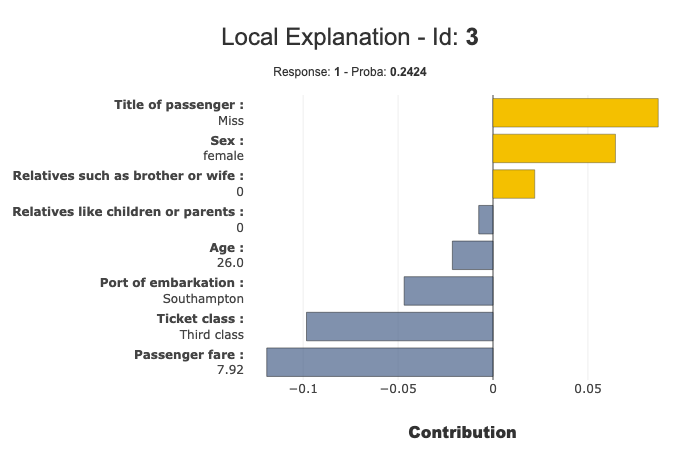

In [14]:
xpl.plot.local_plot(index=3)

In [15]:
summary_df = xpl.to_pandas(max_contrib=3,positive=True,proba=True)
summary_df.head()

,pred,proba,feature_1,value_1,contribution_1,feature_2,value_2,contribution_2,feature_3,value_3,contribution_3
863,1,0.785470,Sex,female,0.192354,Title of passenger,Mrs,0.158498,Ticket class,First class,0.092583
224,0,0.972264,Title of passenger,Mr,0.105669,Passenger fare,7.9,0.074578,Sex,male,0.0693082
85,1,0.826169,Sex,female,0.183571,Title of passenger,Miss,0.177265,Ticket class,Second class,0.083088
681,1,0.686340,Title of passenger,Miss,0.162849,Port of embarkation,Queenstown,0.146734,Sex,female,0.119779
536,1,0.965928,Title of passenger,Miss,0.199437,Ticket class,Second class,0.118737,Sex,female,0.110403
